# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [12]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [1]:
# Install requirements
!python -m pip install -r requirements.txt

  Using cached widgetsnbextension-4.0.13-py3-none-any.whl.metadata (1.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 2.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 1.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 950.2 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 1.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 856.3 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 MB 905.8 kB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 2.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 1.3 MB/s eta 0:00:00a 0:00:01
Using cached widgetsnbextension-4.0.13-py3-none-any.whl (2.3 MB)
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.9
    Uninstalling widgetsnbextension-3.6.9:
      Successfully

## Imports

In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [12]:
%matplotlib inline

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [4]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Create training set and define training dataloader
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# Create test set and define test dataloader
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

**DOUBLE CLICK THIS CELL TO MODIFY**

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [5]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

Train dataset size: 60000
Test dataset size: 10000
Batch shape: torch.Size([64, 1, 28, 28])
Label shape: torch.Size([64])
3


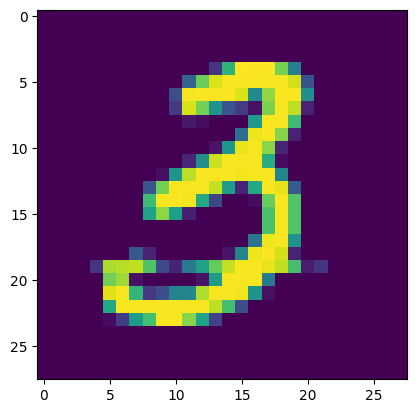

6


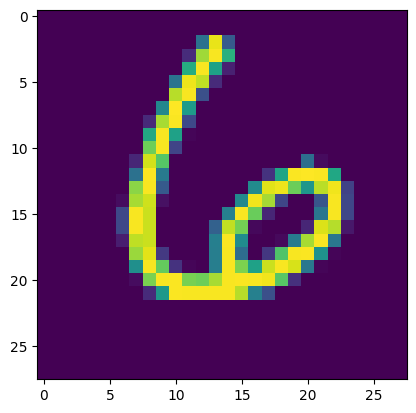

1


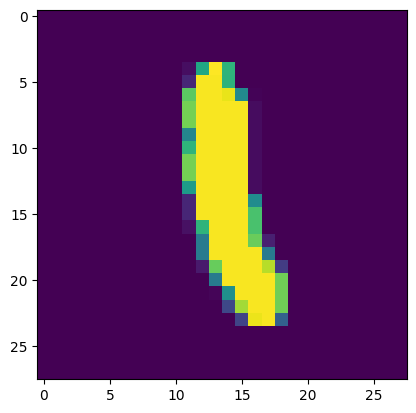

7


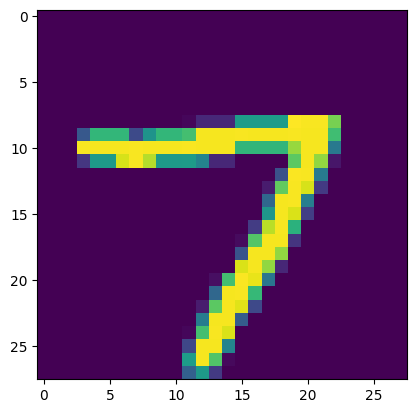

2


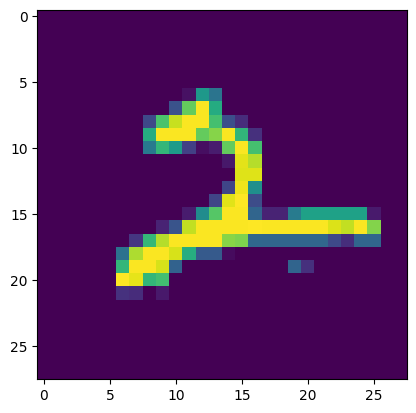


Visualization without normalization:
8


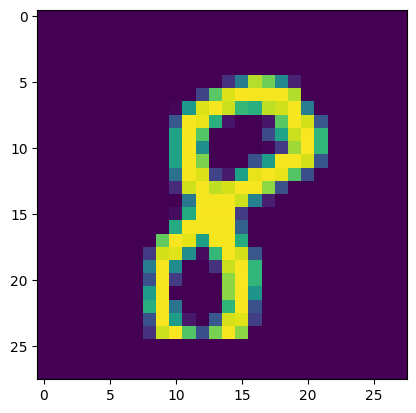

6


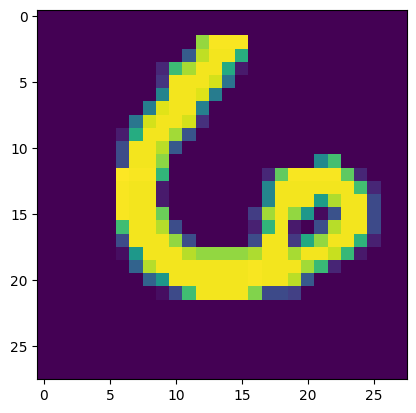

8


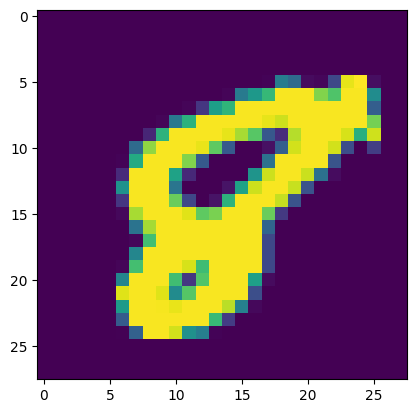

7


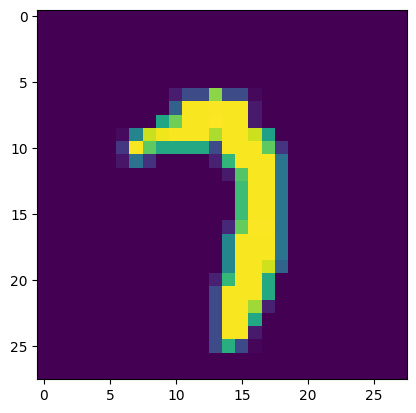

1


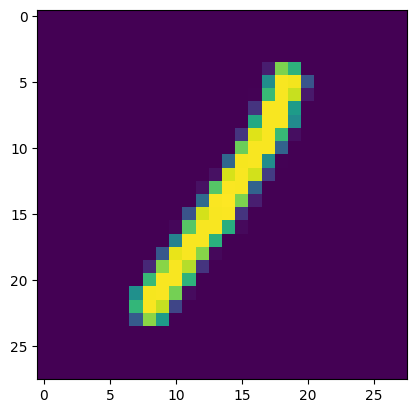

In [14]:
# Explore data
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Get a sample batch
sample_batch = next(iter(train_loader))
print(f"Batch shape: {sample_batch[0].shape}")
print(f"Label shape: {sample_batch[1].shape}")

# Visualize 5 images
show5(train_loader)

# Create a dataloader without normalization for better visualization
transform_viz = transforms.Compose([transforms.ToTensor()])
viz_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_viz)
viz_loader = torch.utils.data.DataLoader(viz_dataset, batch_size=64, shuffle=True)

print("\nVisualization without normalization:")
show5(viz_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

# Instantiate the model
model = Net()

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [8]:
## YOUR CODE HERE ##
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# other examples for personal note 
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# optimizer = optim.RMSprop(model.parameters(), lr=0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [9]:
## YOUR CODE HERE ##
import torch

# I have Apple M2 Machine so this is what we check first, but, this should work with CUDA as well
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# Move model to device
model = model.to(device)

# Training parameters
num_epochs = 10
batch_size = 64
log_interval = 250

# Lists to store metrics
train_losses = []
train_counter = []

def train(epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            train_losses.append(loss.item())
            train_counter.append((batch_idx * batch_size) + ((epoch - 1) * len(train_loader.dataset)))
    
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch} complete. Average loss: {avg_loss:.6f}')
    return avg_loss

# Training loop
epoch_losses = []
for epoch in range(1, num_epochs + 1):
    avg_loss = train(epoch)
    epoch_losses.append(avg_loss)

# Plot training loss
plt.figure()
plt.plot(range(1, num_epochs + 1), epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss per Epoch')
plt.show()

# Plot detailed training loss
plt.figure()
plt.plot(train_counter, train_losses)
plt.xlabel('Number of training examples seen')
plt.ylabel('Negative log likelihood loss')
plt.title('Detailed Training Loss')
plt.show()

Using device: mps


/opt/miniconda3/envs/introai/lib/python3.9/site-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.292096
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.174245
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.216021
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.154971
Epoch 1 complete. Average loss: 0.201215
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.042317
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.018923
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.066636
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.076121
Epoch 2 complete. Average loss: 0.088330
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.062720
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.073133
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.112018
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.100389
Epoch 3 complete. Average loss: 0.069144
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.049003
Train Epoch: 4 [16000/60000 (27%)]	Loss: 0.041378
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.137817
Train Epoch: 4 [48000/60000 (80%)]	Loss: 0.080337
Epoch 4 complete. Average loss: 0.057481
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.004930
Train Epoch

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

Plot the training loss (and validation loss/accuracy, if recorded).

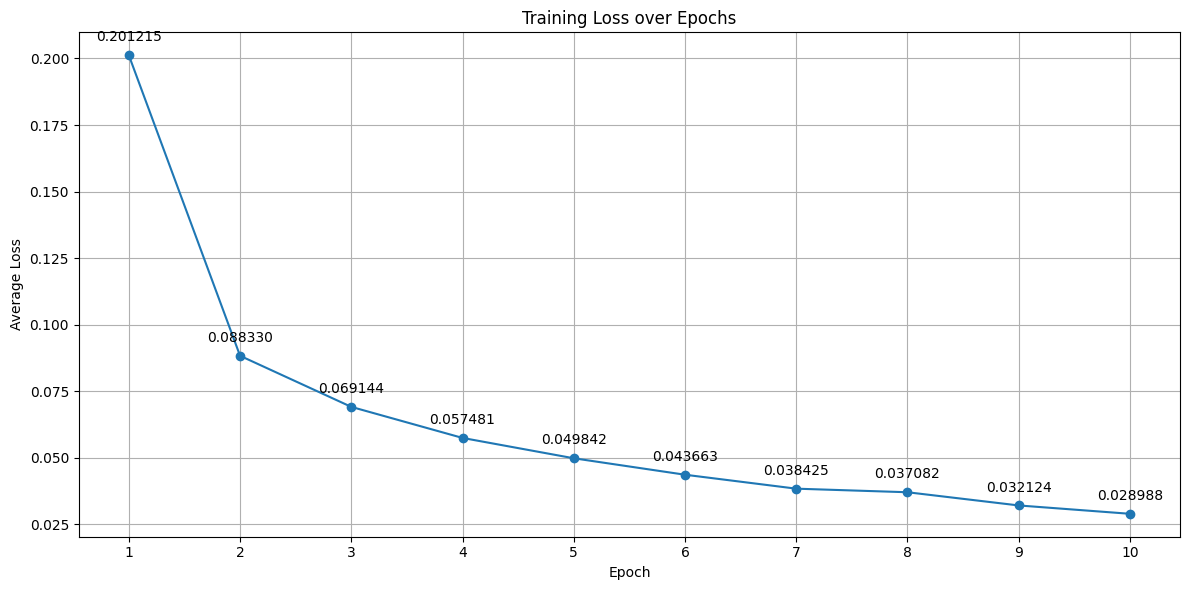

In [13]:
import matplotlib.pyplot as plt

# Extract average losses per epoch from the output
epoch_losses = [0.201215, 0.088330, 0.069144, 0.057481, 0.049842, 0.043663, 0.038425, 0.037082, 0.032124, 0.028988]

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), epoch_losses, marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.xticks(range(1, 11))

# Add data labels
for i, loss in enumerate(epoch_losses):
    plt.annotate(f'{loss:.6f}', (i + 1, loss), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [15]:
## YOUR CODE HERE ##
import torch

def test_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient computation
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

# Assuming you have already defined test_loader and model
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)

# Run the test
test_accuracy = test_model(model, test_loader, device)

print(f'Accuracy on the test set: {test_accuracy:.2f}%')

if test_accuracy > 90:
    print("Great work! Your model is performing well.")
    print("Can you push it further? Try adjusting hyperparameters or adding more layers.")
else:
    print("Your model's accuracy is below 90%.")
    print("Consider reviewing your model architecture, loss function, and optimizer.")
    print("You might also try training for more epochs or adjusting the learning rate.")

Accuracy on the test set: 99.00%
Great work! Your model is performing well.
Can you push it further? Try adjusting hyperparameters or adding more layers.


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

## Model Performance Summary

Our model achieved an accuracy of 99.00% on the test set, which is an excellent result for the MNIST dataset. This level of performance is comparable to state-of-the-art results on this task.

Given this high accuracy, further improvements may yield only marginal gains and could risk overfitting. Instead of trying to improve the model further, we can conclude that:

1. The chosen model architecture is well-suited for this task.

2. Our hyperparameters and training process were effective.

3. The preprocessing and data handling techniques we used were appropriate.

Future work could focus on:

- Analyzing the few misclassified examples to understand edge cases

- Exploring the model's performance on more challenging datasets or real-world handwritten digits

- Investigating techniques to reduce model size or inference time while maintaining high accuracy

This exercise demonstrates the effectiveness of convolutional neural networks for image classification tasks and provides a strong foundation for tackling more complex computer vision problems.

## Saving your model
Using `torch.save`, save your model for future loading.

In [16]:
## YOUR CODE HERE ##

import torch
import os

def save_model(model, filename):
    # Create a 'models' directory if it doesn't exist
    if not os.path.exists('models'):
        os.makedirs('models')
    
    # Full path for the model
    model_path = os.path.join('models', filename)
    
    # Save the model
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

# Assuming your model is named 'model'
model_filename = 'mnist_model.pth'
save_model(model, model_filename)

# Optionally, you can also save additional information
model_info = {
    'architecture': str(model),
    'accuracy': 99.00,  # The accuracy you achieved
    'epochs': 10,  # The number of epochs you trained for
    # Add any other relevant information
}

info_filename = 'mnist_model_info.pth'
torch.save(model_info, os.path.join('models', info_filename))
print(f"Model info saved to {os.path.join('models', info_filename)}")

Model saved to models/mnist_model.pth
Model info saved to models/mnist_model_info.pth


## To use this saved model in the future, we can use the code:

In [17]:
import torch

def load_model(model, filename):
    model_path = os.path.join('models', filename)
    model.load_state_dict(torch.load(model_path))
    print(f"Model loaded from {model_path}")
    return model

# Assuming you have your model class defined as 'Net'
loaded_model = Net()
loaded_model = load_model(loaded_model, 'mnist_model.pth')

# Load the model info if you saved it
model_info = torch.load(os.path.join('models', 'mnist_model_info.pth'))
print("Model info:", model_info)

# Don't forget to call model.eval() if you're using the model for inference
loaded_model.eval()

Model loaded from models/mnist_model.pth
Model info: {'architecture': 'Net(\n  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))\n  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))\n  (dropout1): Dropout2d(p=0.25, inplace=False)\n  (dropout2): Dropout2d(p=0.5, inplace=False)\n  (fc1): Linear(in_features=9216, out_features=128, bias=True)\n  (fc2): Linear(in_features=128, out_features=10, bias=True)\n)', 'accuracy': 99.0, 'epochs': 10}


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)